# Performance of LLMs on the GPQA benchmark
This notebook examines the performance of various large language models (LLMs) on the GPQA dataset.

Hugging Face dataset: https://huggingface.co/datasets/Idavidrein/gpqa
* We use the `gpqa_main` subset filtering question by `df['Domain'] == 'Biology'`

Paper: https://arxiv.org/abs/2311.12022

## Setup

In [32]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from datetime import datetime

In [33]:
results_df_path = 'results.csv'

log_files_dir = 'logs/'

model_dir_names = [
    'gpt-4o',
    'gemini-1.5-pro',
    'claude-3.5-sonnet',
    'llama-3.1-405b'
]

models_data_file = '../../../models/models_data.tsv'

large_scale_models_file = '../../../models/epoch-data/large_scale_ai_models.csv'
notable_models_file = '../../../models/epoch-data/notable_ai_models.csv'

## Process metadata
First, we merge two Epoch datasets containing model metadata into a single dataframe. 

[1] https://epochai.org/data/large-scale-ai-models  
[2] https://epochai.org/data/notable-ai-models

Then, we merge the Epoch data with manually collected model metadata.

In [34]:
def merge_epoch_datasets(notable_file, large_scale_file):
    """"""
    
    notable_df = pd.read_csv(notable_file)
    large_scale_df = pd.read_csv(large_scale_file)
    epoch_df = pd.concat([notable_df, large_scale_df], ignore_index=True)
    epoch_df = epoch_df.drop_duplicates(subset='System', keep='first')
    return epoch_df

epoch_data = merge_epoch_datasets(notable_models_file, large_scale_models_file)

In [35]:
models_df = pd.read_csv(models_data_file, sep='\t')

# models_metadata = models_df.merge(epoch_data, left_on='epoch_model_name', right_on='System', how='left')

## Load results from Inspect
Load the contents of a log directory into a dataframe and compute estimated cost per run.

In [36]:
def clean_cost(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', ''))
    return float(value)

def calculate_cost(input_tokens, output_tokens, model_name, models_df):
    model_data = models_df[models_df['inspect_model_name'] == model_name].iloc[0]
    input_cost_per_M = clean_cost(model_data['input_cost_per_M_tokens'])
    output_cost_per_M = clean_cost(model_data['output_cost_per_M_tokens'])
    cost_per_M = clean_cost(model_data['cost_per_M_tokens'])
    
    if input_cost_per_M and output_cost_per_M:
        input_cost = (input_cost_per_M / 1_000_000) * input_tokens
        output_cost = (output_cost_per_M / 1_000_000) * output_tokens
        total_cost = input_cost + output_cost
    elif cost_per_M:
        total_cost = (cost_per_M / 1_000_000) * (input_tokens + output_tokens)
    else:
        total_cost = 0
    
    return round(total_cost, 2)

def process_log_files(log_files_dir, model_dir_names):
    results = []
    
    for model_dir in model_dir_names:
        log_path = os.path.join(log_files_dir, model_dir)
        for filename in os.listdir(log_path):
            if filename.endswith('.json'):
                file_path = os.path.join(log_path, filename)
                with open(file_path, 'r') as f:
                    log = json.load(f)
                
                if log['status'] == "success":
                    model_name = log['eval']['model']
                    
                    # Extract data from logs
                    accuracy = next((score['metrics']['accuracy']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                    stderr = next((score['metrics']['stderr']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                    token_usage = sum(usage['total_tokens'] for usage in log['stats']['model_usage'].values())
                    task_name = log['eval']['task']
                    dataset_samples = log['eval']['dataset']['samples']
                    completed_samples = log['results']['completed_samples']
                    input_tokens = sum(usage['input_tokens'] for usage in log['stats']['model_usage'].values())
                    output_tokens = sum(usage['output_tokens'] for usage in log['stats']['model_usage'].values())
                    start_time = log['stats']['started_at']
                    end_time = log['stats']['completed_at']
                    
                    # Calculate cost for this run
                    run_cost = calculate_cost(input_tokens, output_tokens, model_name, models_df)
                    
                    results.append({
                        'inspect_model_name': model_name,
                        'accuracy': accuracy,
                        'stderr': stderr,
                        'total_tokens': token_usage,
                        'input_tokens': input_tokens,
                        'output_tokens': output_tokens,
                        'task': task_name,
                        'dataset_samples': dataset_samples,
                        'completed_samples': completed_samples,
                        'run_id': log['eval']['run_id'],
                        'created': log['eval']['created'],
                        'start_time': start_time,
                        'end_time': end_time,
                        'filename': filename,
                        'estimated_cost': run_cost
                    })
        
    return pd.DataFrame(results)

results_df = process_log_files(log_files_dir, model_dir_names)

In [37]:
gpqa_df = results_df.merge(models_df, left_on='inspect_model_name', right_on='inspect_model_name', how='left')
gpqa_df.to_csv(results_df_path, index=False)
gpqa_df.head()

,inspect_model_name,accuracy,stderr,total_tokens,input_tokens,output_tokens,task,dataset_samples,completed_samples,run_id,...,filename,estimated_cost,epoch_model_name,biggest_in_class,cost_per_M_tokens,input_cost_per_M_tokens,output_cost_per_M_tokens,cost_source,api_source,last_updated
0,openai/gpt-4o,0.692308,0.052597,23937,23703,234,benchmarks/gpqa,78,78,D9UwfzcALm7VRqePLcXjhz,...,2024-09-26T21-40-00-04-00_benchmarks-gpqa_Rxum...,0.12,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
1,openai/gpt-4o,0.666667,0.053722,23952,23703,249,benchmarks/gpqa,78,78,FrUnyrhMJpy3UJsNVbsx2X,...,2024-09-26T21-39-31-04-00_benchmarks-gpqa_eRti...,0.12,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
2,openai/gpt-4o,0.679487,0.053182,23945,23704,241,benchmarks/gpqa,78,78,JLdadQVNkKh65AdCqgW68h,...,2024-09-26T21-40-06-04-00_benchmarks-gpqa_TVAt...,0.12,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
3,openai/gpt-4o,0.641026,0.054667,23938,23704,234,benchmarks/gpqa,78,78,TUdYkEQCzEfXmEtCZWr3qg,...,2024-09-26T21-39-36-04-00_benchmarks-gpqa_3DVS...,0.12,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
4,openai/gpt-4o,0.666667,0.053722,23935,23701,234,benchmarks/gpqa,78,78,3izALw6Z5t2aEJukc5qp5w,...,2024-09-26T21-39-55-04-00_benchmarks-gpqa_56ar...,0.12,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03


## Cost analysis

In [38]:
cost_summary = gpqa_df.groupby('inspect_model_name').agg({
    'estimated_cost': ['count', 'sum', 'mean'],
    'input_tokens': 'sum',
    'output_tokens': 'sum'
}).reset_index()
cost_summary.head()

cost_summary.columns = [
    'Model', 'Total Runs', 'Estimated Total Cost', 'Estimated Average Cost per Run',
    'Total Input Tokens', 'Total Output Tokens'
]

cost_summary = cost_summary[[
    'Model', 'Total Runs', 'Total Input Tokens', 'Total Output Tokens',
    'Estimated Total Cost', 'Estimated Average Cost per Run'
]]

print("Cost Analysis for GPQA Benchmark:")
print(cost_summary.to_string(index=False))

# Calculate and display the grand total cost
grand_total_cost = cost_summary['Estimated Total Cost'].sum()
print(f"\nEstimated Total Cost for all models: ${grand_total_cost:.2f}")

Cost Analysis for GPQA Benchmark:
                                                 Model  Total Runs  Total Input Tokens  Total Output Tokens  Estimated Total Cost  Estimated Average Cost per Run
                  anthropic/claude-3-5-sonnet-20240620          10              272710                 5357                  0.90                           0.090
                                 google/gemini-1.5-pro          10              227362                 2340                  0.80                           0.080
                                         openai/gpt-4o          10              237024                 2362                  1.20                           0.120
together/meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo          10              263441                58253                  1.61                           0.161

Estimated Total Cost for all models: $4.51


<Figure size 1200x800 with 0 Axes>

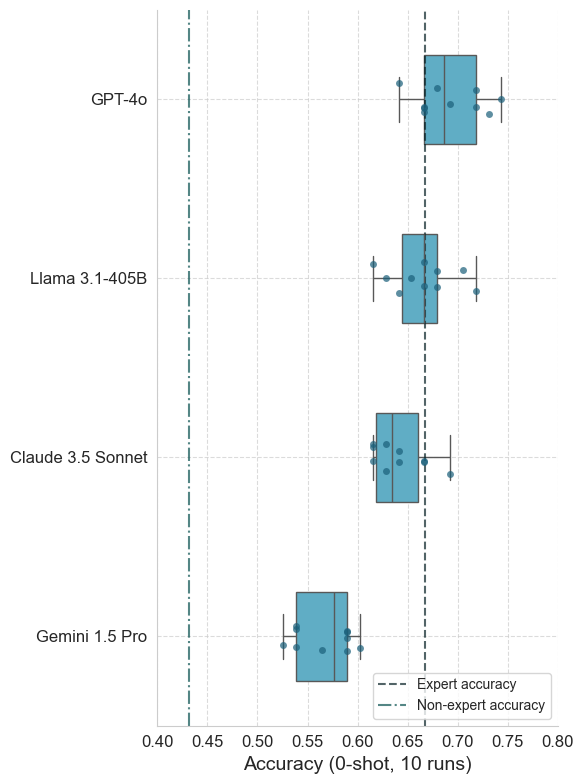

In [49]:
# Set up the plot style
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(6, 8))

# Define colors
box_color = '#4FB6D6'
point_color = '#1A5F7A'

# Create box plot sorted by median
sns.boxplot(x='accuracy', y='epoch_model_name', data=gpqa_df, 
            ax=ax, color=box_color, width=0.5, 
            showfliers=False, order=gpqa_df.groupby('epoch_model_name')['accuracy'].median().sort_values(ascending=False).index)

# Add jittered points
sns.stripplot(x='accuracy', y='epoch_model_name', data=gpqa_df, 
              ax=ax, color=point_color, alpha=0.7, size=5, 
              jitter=True, order=gpqa_df.groupby('epoch_model_name')['accuracy'].median().sort_values(ascending=False).index)

# Customize the plot
ax.set_xlabel('Accuracy (0-shot, 10 runs)', fontsize=14)
ax.set_ylabel('')
ax.set_xlim(.4, .8)
# ax.set_xticks(np.arange(0.4, 0.76, 0.05))
# ax.set_xticklabels([f'{x:.0%}' for x in np.arange(0.4, 0.76, 0.05)])

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add reference lines
ax.axvline(x=0.667, color='#092327', linestyle='--', alpha=0.7, label='Expert accuracy')
ax.axvline(x=0.432, color='#0b5351', linestyle='-.', alpha=0.7, label='Non-expert accuracy')
# ax.axvline(x=0.25, color='#00a9a5', linestyle=':', alpha=0.7, label='Random guess')

# Add legend
ax.legend(fontsize=10, loc='lower right')

# Add title
#plt.title('Model accuracy on GPQA_main biology questions', fontsize=16, fontweight='bold')

# Add subtitle
# plt.text(0.5, 1.05, 'Box shows IQR. Whiskers extend to min and max. Center line is median. Points represent individual runs.',
#          horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.savefig('gpqa_accuracy_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x800 with 0 Axes>

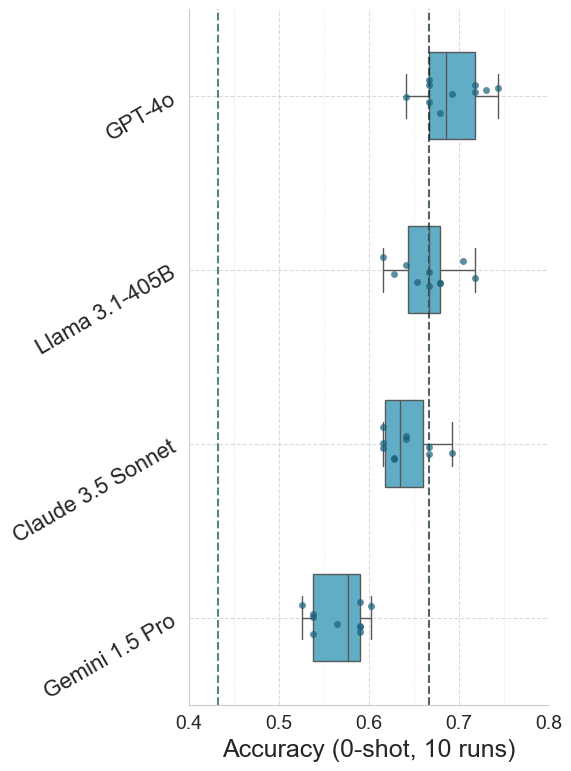

In [51]:
# Set up the plot style
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Roboto'  # Updated to use Roboto font
plt.rcParams['font.size'] = 16  # Increased font size
sns.set_style("whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(6, 8))

# Define colors
box_color = '#4FB6D6'
point_color = '#1A5F7A'

# Create box plot sorted by median
sns.boxplot(x='accuracy', y='epoch_model_name', data=gpqa_df, 
            ax=ax, color=box_color, width=0.5, 
            showfliers=False, order=gpqa_df.groupby('epoch_model_name')['accuracy'].median().sort_values(ascending=False).index)

# Add jittered points
sns.stripplot(x='accuracy', y='epoch_model_name', data=gpqa_df, 
              ax=ax, color=point_color, alpha=0.7, size=5, 
              jitter=True, order=gpqa_df.groupby('epoch_model_name')['accuracy'].median().sort_values(ascending=False).index)

# Customize the plot
ax.set_xlabel('Accuracy (0-shot, 10 runs)', fontsize=18)  # Increased font size for labels
ax.set_ylabel('')
ax.set_xlim(.4, .8)
ax.set_xticks(np.arange(0.4, 0.81, 0.1))  # Set x-axis ticks every 0.1
ax.set_xticklabels([f'{x:.1f}' for x in np.arange(0.4, 0.81, 0.1)], fontsize=14)  # Set tick labels every 0.1

ax.tick_params(axis='y', labelrotation=30)

# Add minor grid lines
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=0.7)

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axvline(x=0.667, color='#092327', linestyle='--', alpha=0.7, label='Expert accuracy')
ax.axvline(x=0.432, color='#0b5351', linestyle='--', alpha=0.7, label='Non-expert accuracy')
# ax.legend(fontsize=10, loc='lower right')

# Adjust layout and display
plt.tight_layout()
plt.savefig('gpqa_accuracy_boxplot_updated.png', dpi=300, bbox_inches='tight')
plt.show()